In [1]:
# Kristina Fauss
# April 19, 2024
# model selection by AIC testing all 1st order interactions

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.stats.multitest import multipletests

from ols_mixedef_custom import *

In [2]:
fp = '/Users/kristinafauss/BackupToBox/Git/lab-flammability-testing-2022/data/processed-data/main_dataset.csv'

flamog = pd.read_csv(fp)

# drop na's for flam metrics
print(len(flamog))
for col in ['fh', 'fd', 'pfg', 'temp_change', 'heat_flux_change']:
    flamog.dropna(subset=col, inplace=True)
print(len(flamog))

flamog['plant_id']=[str(a)+'_'+str(b) for a,b in zip(flamog['plant'], flamog['species'])]

# drop hetarb - only 2 data points
flamog = flamog[flamog.species!='HETARB']
# report
print(flamog.columns)
flamog.head()

172
171
Index(['Unnamed: 0', 'species', 'plant', 'date', 'total_branch_mass',
       'total_leaf_mass', 'stem_mass_ratio', 'leaf_mass_ratio', 'leaf_lfm',
       'thickness', 'leaf_wet_mass', 'leaf_dry_mass', 'stem_lfm', 'stem_width',
       'stem_wet_mass', 'stem_dry_mass', 'stem_sav', 'lfm', 'leaf_dmc',
       'stem_dmc', 'dmc', 'leaf_area', 'leaf_sav', 'LMA', 'SLA', 'rep',
       'branch_length', 'branch_width', 'branch_height', 'sample_wt',
       'no_branches', 'mpa', 'notes_on_plant_char', 'start_time',
       'ambient_temp', 'ambient_humidity', 'pre_ignition_glow',
       'first_glow_time', 'ignition', 'primary_ignition',
       'primary_time_of_flame_end', 'secondary_ignition',
       'secondary_time_of_flame_end', 'third_ignition',
       'third_time_of_ignition_flame_end', 'time_fh', 'fh', 'time_of_glow_end',
       'end_time', 'thermocoupler_height', 'hotplate_height',
       'notes_on_flam_data', 'fd', 'tti', 'pfg', 'max_temp',
       'time_at_max_temp', 'max_temp_sensor', '

Unnamed: 0 species  plant        date  total_branch_mass  total_leaf_mass  \
0           1  ARCDEN      1  2022-08-10             20.347           19.505   
1           2  ARCDEN      1  2022-08-10             20.347           19.505   
2           3  ARCDEN      1  2022-08-10             20.347           19.505   
3           4  ARCDEN      1  2022-08-10             20.347           19.505   
4           5  ARCDEN      1  2022-08-10             20.347           19.505   

   stem_mass_ratio  leaf_mass_ratio   leaf_lfm  thickness  ...  wet_mass  \
0         0.510564         0.489436  251.06912      0.514  ...     1.151   
1         0.510564         0.489436  251.06912      0.514  ...     1.151   
2         0.510564         0.489436  251.06912      0.514  ...     1.151   
3         0.510564         0.489436  251.06912      0.514  ...     1.151   
4         0.510564         0.489436  251.06912      0.514  ...     1.151   

   dry_mass   gdw_gfw  dw_flam_sample  ww_flam_sample  branch_volume  \
0    0.3683  0.242414        1.291195        4.035205        1082.04   
1    0.3683  0.242414        1.429372        4.467028        1370.20   
2    0.3683  0.242414        1.283923        4.012477         682.04   
3    0.3683  0.242414        1.283923        4.012477        1262.25   
4    0.3683  0.242414        0.811215        2.535185         819.00   

   branching  sample_density  dw_sppdev  plant_id  
0   0.416667        0.004923   0.923122  1_ARCDEN  
1   0.322581        0.004303   1.348152  1_ARCDEN  
2   0.294118        0.007766   0.900752  1_ARCDEN  
3   0.466667        0.004196   0.900752  1_ARCDEN  
4   0.500000        0.004086  -0.553297  1_ARCDEN  

[5 rows x 81 columns]

In [3]:
flamog.species.value_counts()

species
ERIKAR    37
SALLEU    36
CEAGRI    29
SALAPI    22
MALLAU    20
ARTCAL    13
ARCDEN     8
Name: count, dtype: int64

# Examine Correlation & Structure in Num. Var's

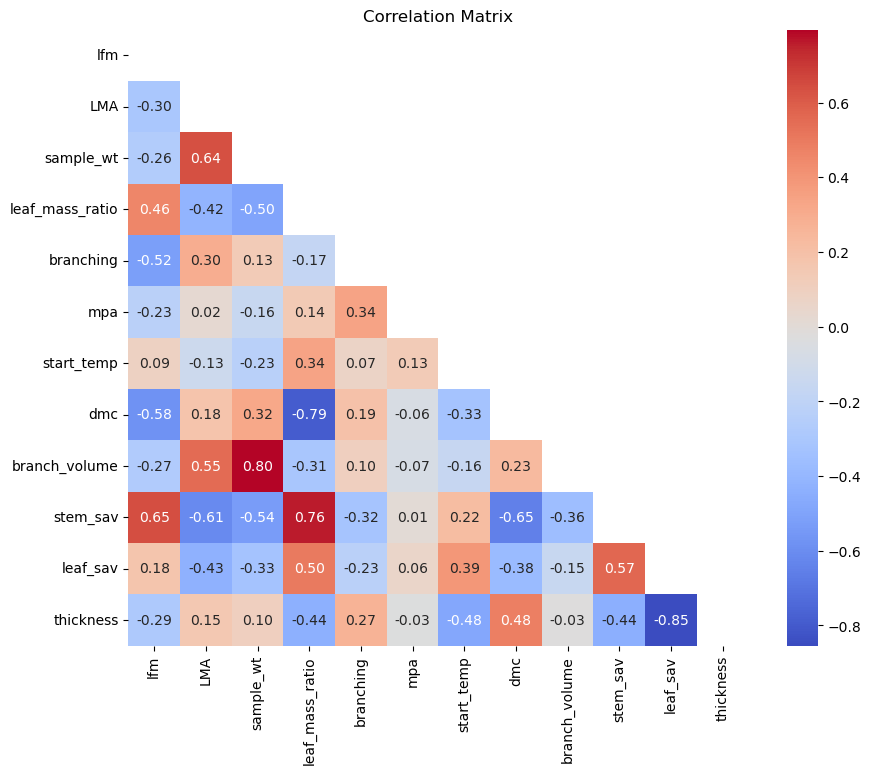

In [4]:
cols_num_use = ['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']

corrplot(flamog, cols_num_use)

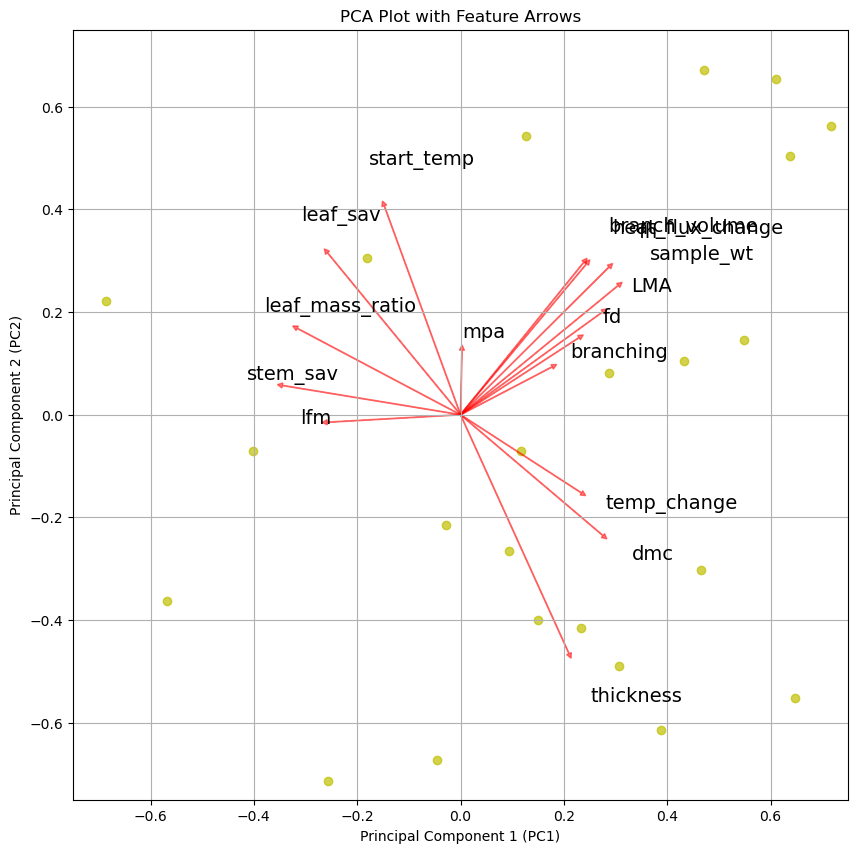

In [5]:
PCAplot(flamog, cols_num_use+['fh','fd','temp_change','heat_flux_change'])

# Modeling Preprocessing

In [6]:
# scale and center
cols_all = ['fh', 'fd', 'temp_change', 'heat_flux_change'] + cols_num_use
flam = scale_and_center(flamog, cols_all, cols_no_change=['plant_id', 'species', 'ignition'])

# declare as factors
flam['species'] = pd.Categorical(flam['species'])
flam['plant_id'] = pd.Categorical(flam['plant_id'])
flam['ignition'] = pd.Categorical(flam['ignition'])

# drop na's
print(len(flam))
cols_all_dpna = cols_all + ['plant_id', 'species', 'ignition']
flam.dropna(subset=cols_all_dpna, inplace=True)
print(len(flam))

# declare all possible IV cols to model
cols_use = cols_num_use #+ ['species']
print(cols_use)

165
158
['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']


## HFX

In [15]:
y='heat_flux_change'
df=flam

## examine each variable's LM within species groups

print if near significant

In [16]:
pthresh=0.15

for var in cols_use:
    print('\n\n', var)
    formula = y + '~' + var
    for spec in flam.species.unique():
        flami=flam[flam.species==spec]
        model = smf.ols(formula, data=flami)
        results = model.fit(reml=False)
        if results.pvalues[1] < pthresh:
            print(spec)
            print(results.params[1], results.pvalues[1])
            #sns.regplot(x= flami.lfm, y= flami.fh);



 lfm
CEAGRI
0.925750543397043 0.01685453954678942
MALLAU
-0.9417583099259496 0.025403829958247085


 LMA
ARTCAL
0.22849650680564476 0.005066531599273964
ERIKAR
1.6420683983375544 0.0002317395100661397
MALLAU
0.8120833436480748 0.06986631685701225


 sample_wt
CEAGRI
0.7484151982604279 0.003074437980791624
ERIKAR
2.2667423858157463 0.06557020081368245
MALLAU
0.6788007134418177 0.006746741725905462
SALAPI
1.0914555516906805 1.8715761153219273e-05
SALLEU
0.7251223253902167 8.465824781162261e-06


 leaf_mass_ratio
ERIKAR
1.1581817791456372 0.03202740389781307
MALLAU
-0.7465381309598715 0.09432029280136559


 branching
ERIKAR
0.50898274579753 0.01644042104506529
MALLAU
0.5507485094472926 0.11231692879080153
SALLEU
0.26350110554878786 0.0008191368530833524


 mpa
ARTCAL
-0.4919097256504522 0.017360237383801477
ERIKAR
-0.2306600728348049 0.005526360538694229


 start_temp
ERIKAR
0.38169472684556804 0.023962669711507997


 dmc
CEAGRI
-2.117762376969505 0.00010734832387672065
ERIKAR
-3.214057

## examine each variables significance and ranking by AIC outside in Mixed LM structure
(tests each independently and reports together)

In [17]:
yvar=y
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0               mpa  411.826041 -0.046794  6.066879e-01     True
1         thickness  411.597043  0.081887  4.818602e-01     True
2               dmc  410.370768  0.142433  1.813702e-01     True
3        start_temp  409.489495  0.152893  1.064645e-01    False
4               lfm  407.509224 -0.302763  3.131805e-02    False
5          leaf_sav  407.063694 -0.289654  3.109377e-02    False
6   leaf_mass_ratio  406.447131 -0.288720  9.929759e-03    False
7          stem_sav  405.623189 -0.354519  1.509678e-03    False
8         branching  404.072725  0.223362  3.867067e-03    False
9               LMA  391.352558  0.534987  6.245420e-07    False
10    branch_volume  391.130515  0.396857  1.602737e-06    False
11        sample_wt  331.797298  0.728534  1.295792e-20    False


### test correlation of top predictors
`thickness` and `leaf_sav` are too correlated

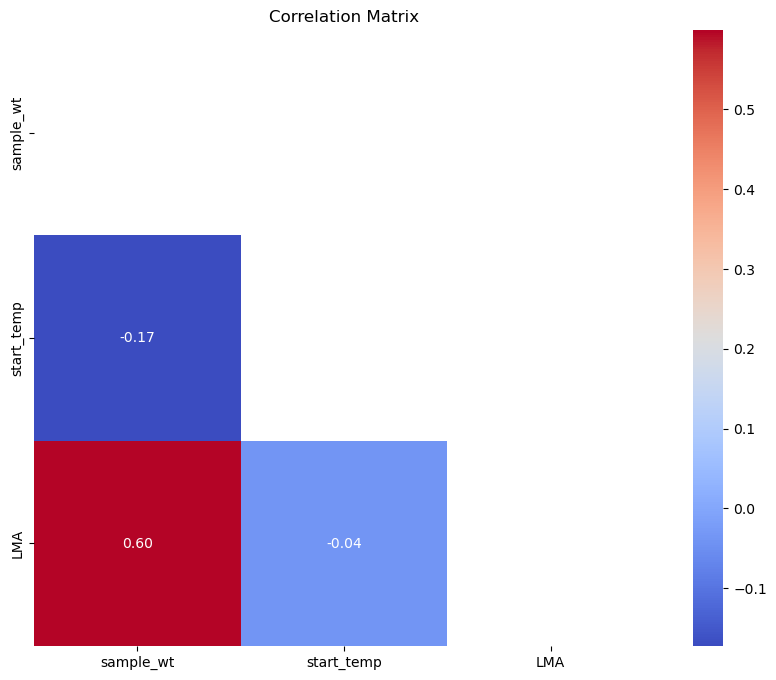

In [40]:
corrplot(flam, ['sample_wt', 'start_temp', 'LMA'])

In [19]:
# heat_flux_change ~ sample_wt*start_temp + LMA
# heat_flux_change ~ sample_wt*start_temp + LMA + thickness
# heat_flux_change ~ sample_wt*start_temp + LMA + stem_sav
# heat_flux_change ~ sample_wt*start_temp + LMA + leaf_sav
# heat_flux_change ~ sample_wt*start_temp + LMA + branching
# heat_flux_change ~ sample_wt*start_temp + lfm + LMA
# heat_flux_change ~ sample_wt*start_temp + LMA + mpa
# heat_flux_change ~ sample_wt*start_temp + LMA + dmc
# heat_flux_change ~ sample_wt*start_temp
# heat_flux_change ~ sample_wt*start_temp
# heat_flux_change ~ sample_wt*start_temp + LMA + branch_volume
# heat_flux_change ~ sample_wt*start_temp + LMA + leaf_mass_ratio

## examine candidate formula(s) for publication

Joe’s Model: 318.9
- `hx ~ sample_wt*leaf_mass_ratio`
  
My Model: 308.4
- `hx ~ sample_wt*start_temp + LMA`
- model consistenly selects that ^ base and sometimes another var, adding in those other vars does not significantly improve the model

VIFmax: 1.628349559755172
AIC: 308.39909090360106
[1.0, 9.113482475759297e-18, 0.038337285177888245, 8.206816703451763e-05, 0.3166488715410335, 1.0, 0.017848161564585324]


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2075          
Min. group size:     8         Log-Likelihood:       -146.1995       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.094    0.138 -0.685 0.493 -0.364  0.176
sample_wt                   0.644    0.073  8.806 0.000  0.501  0.788
start_temp                  0.186    0.067  2.778 0.005  0.055  0.317
sample_wt:start_temp       -0.313    0.071 -4.383 0.000 -0.453 -0.173
LMA                         0.240    0.120  2.002 0.045  0.005  0.474
Group Var                   0.062    0.160                           
C(species):C(plant_id) Var  0.356    0.259                           
=====================================================================

"""

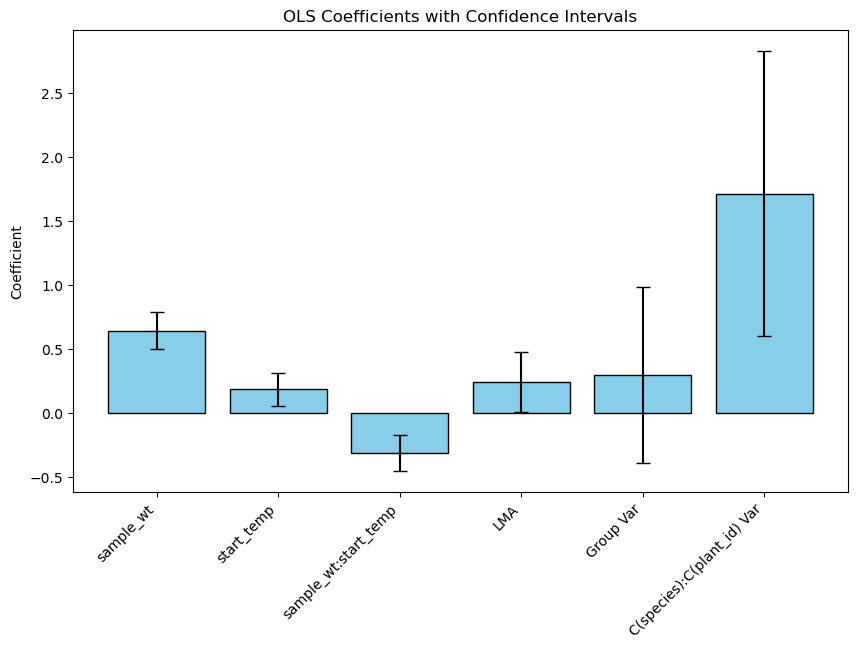

In [42]:
formula = y + '~ sample_wt*start_temp + LMA'

cols_list = ['sample_wt', 'start_temp', 'LMA']

# check VIF
X = flam[cols_list] 
X['int1'] = flam.sample_wt*flam.lfm
print('VIFmax:', max([variance_inflation_factor(X.values, i) for i in range(len(X.columns))]))

# model
model = smf.mixedlm(formula, data=flam, groups=flam["species"], re_formula='1', vc_formula={'C(species):C(plant_id)': '0 + C(plant_id)'})
results = model.fit(reml=False)

# report
plot_ols_coefficients(results)
print('AIC:', results.aic)
# print adjusted pvals
print([i for i in multipletests(results.pvalues, method='bonferroni')[1]])
results.summary()

## interpretation of candidate model

`hx ~ sample_wt*start_temp + LMA`

- HX increases with increasing mass, LMA
- Relationship with `start_temp` looks flat


Interpret/why ecol??

### within species patterns

- The relationship with `start_temp` is weak across species
- HX broadly increasing with `start_temp` across species
- HX broadly increasing with LMA

Why should HX increase with LMA?
- LMA = leaf mass per area, the ratio between leaf dry mass and leaf area
- increasing LMA means leaf has more dry mass per unit area - should mean thicker/heftier leaf
- leaves support flaming ignition -> more dry mass/area = more energy / unit leaf area

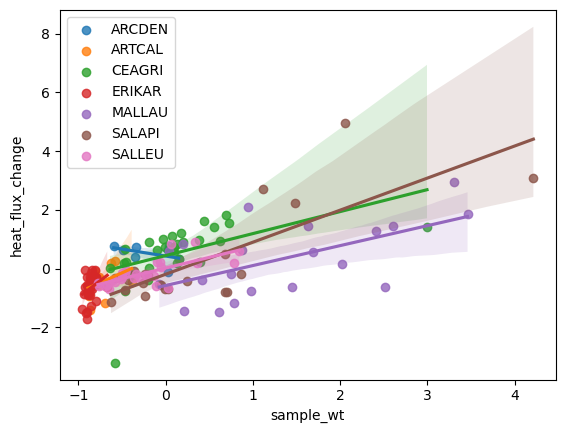

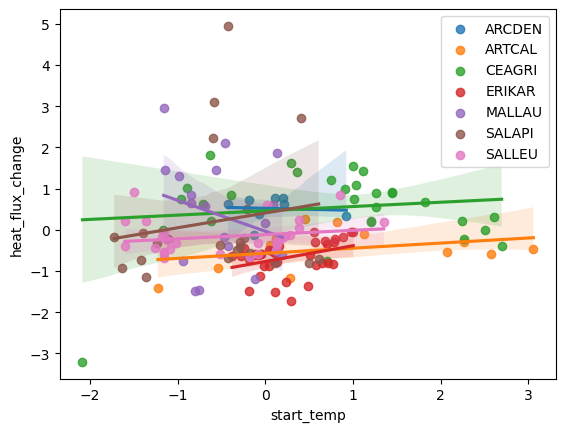

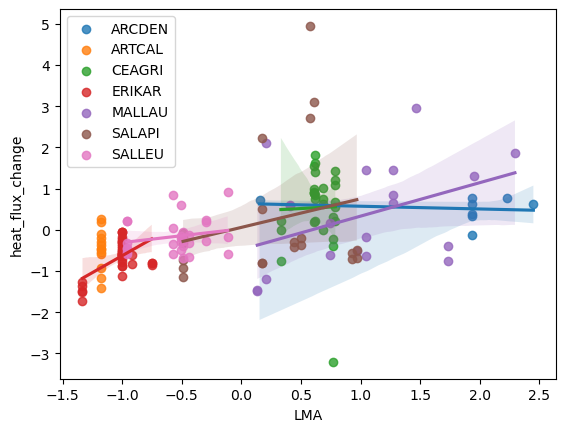

In [37]:
for col in cols_list:
    for spec in flam.species.unique():
        flami = flam[flam.species==spec]
        sns.regplot(x=col, y=y, data=flami, label=spec)#, ci=None, order=2)
    plt.legend()
    plt.show();

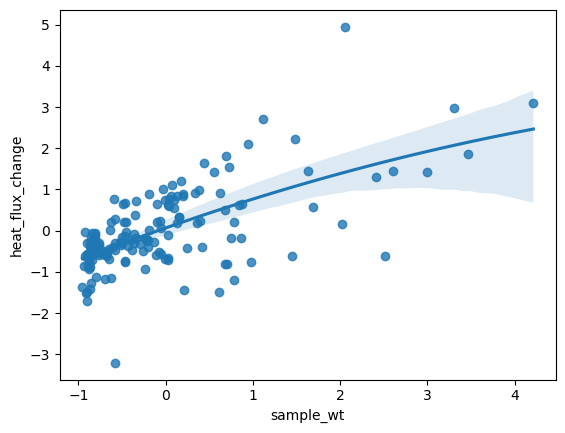

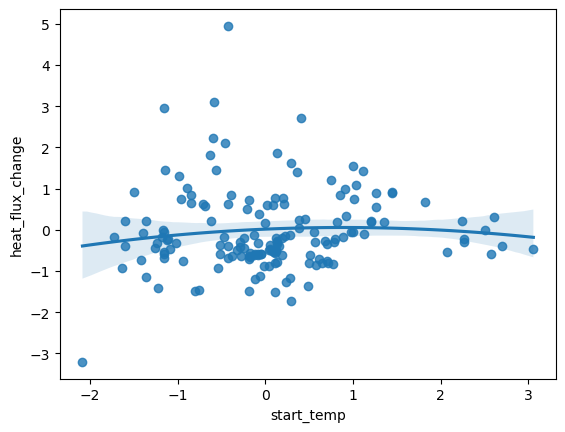

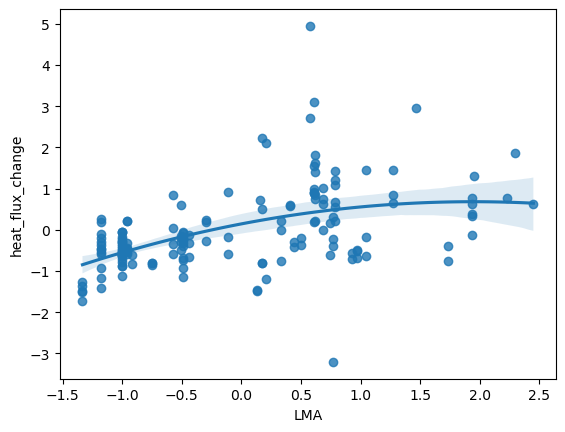

In [38]:
for col in cols_list:
    sns.regplot(x=col, y=y, data=flam, order=2)
    plt.show();

In [39]:
for var in cols_list:
    print('\n\n', var)
    formula = y + '~' + var
    for spec in flam.species.unique():
        flami=flam[flam.species==spec]
        model = smf.ols(formula, data=flami)
        results = model.fit(reml=False)
        print(spec)
        print(results.params[1], results.pvalues[1])
        #sns.regplot(x= flami.lfm, y= flami.fh);



 sample_wt
ARCDEN
-0.4744657198696452 0.2729423736307413
ARTCAL
1.331384417831388 0.19347539855974616
CEAGRI
0.7484151982604279 0.003074437980791624
ERIKAR
2.2667423858157463 0.06557020081368245
MALLAU
0.6788007134418177 0.006746741725905462
SALAPI
1.0914555516906805 1.8715761153219273e-05
SALLEU
0.7251223253902167 8.465824781162261e-06


 start_temp
ARCDEN
-0.04873777150440242 0.8795201958015619
ARTCAL
0.12334944819790875 0.2770562784079288
CEAGRI
0.10407131734767591 0.48180887202156086
ERIKAR
0.38169472684556804 0.023962669711507997
MALLAU
-0.7494658828625973 0.2494409052023529
SALAPI
0.3583128690433953 0.48737627522374016
SALLEU
0.10263236361437275 0.3067206254672377


 LMA
ARCDEN
-0.06631001929807728 0.7202525480602393
ARTCAL
0.22849650680564476 0.005066531599273964
CEAGRI
0.1498851978219075 0.9138512511434443
ERIKAR
1.6420683983375544 0.0002317395100661397
MALLAU
0.8120833436480748 0.06986631685701225
SALAPI
0.6942709254332232 0.27735870733851264
SALLEU
0.33331350621338834 0.274